# Predicción del IMACEC usando modelos SARIMA

En este documento se muestra cómo hacer una predicción del IMACEC, el índice mensual de actividad económica del Banco Central, usando modelos SARIMA (Seasonal Autoregressive Integrated Moving Average).

El IMACEC es una variable de frecuencia mensual, con marcada estacionalidad, lo que la hace ideal para demostrar el uso de este tipo de modelos.

Los datos de IMACEC, entre enero de 2003 y mayo de 2020, se obtuvieron de la Base de Datos Estadísticos del Banco Central:
https://si3.bcentral.cl/siete

A continuación se cargan los paquetes utilizados en el análisis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Luego, se cargan los datos y se da un primer vistazo a sus características. Se tienen 209 observaciones, entre enero del 2003 y mayo del 2020.

In [2]:
imacec = pd.read_csv('Imacec.csv', index_col='fecha', parse_dates=True)
print(imacec.info)

<bound method DataFrame.info of                 imacec
fecha                 
2003-01-01   61.196663
2003-02-01   58.653526
2003-03-01   66.093776
2003-04-01   64.066394
2003-05-01   63.873809
...                ...
2020-01-01  110.101204
2020-02-01  106.975023
2020-03-01  114.485498
2020-04-01   99.081445
2020-05-01   98.471553

[209 rows x 1 columns]>


En la siguiente celda se gráfica el IMACEC. Se observa un marcado componente estacional en esta serie de tiempo.

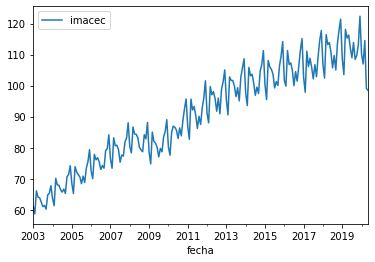

In [3]:
# Gráfico del Imacec
fig, ax = plt.subplots()
imacec.plot(ax=ax)
plt.show()

Luego se calcula la tasa de crecimiento anual del IMACEC, y se grafica. De esta manera se elimina la tendencia y el componente estacional, a la vez que se revela la dinámica del ciclo económico. Se observa un marcado deterioro de la actividad económica durante los últimos periodos de la serie, debido a la pandemia de COVID-19.

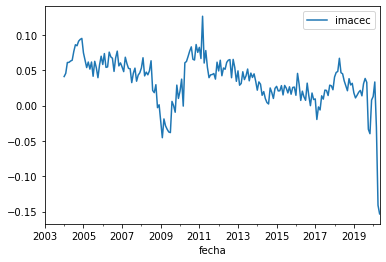

In [4]:
# Crecimiento anual del Imacec
imacec12 = imacec.diff(12)/imacec.shift(12).dropna()
fig, ax = plt.subplots()
imacec12.plot(ax=ax)
plt.show()


Para evitar las distorsiones que podría provocar la dinámica reciente del IMACEC en las estimaciones, se optó por utilizar una submuestra de datos, hasta diciembre de 2019, lo que también permite tener sólo años completos en la muestra. Además, se obtuvo una segunda submuestra, hasta diciembre de 2016 para realizar las estimaciones. El resto de la serie de tiempo servirá para comparar las predicciones del modelo con los datos reales de IMACEC.

In [5]:
imacec = imacec[:'2019']
print(imacec.shape)
imacec_test = imacec
imacec = imacec[:'2016']
print(imacec.shape)

(204, 1)
(168, 1)


A continuación se gráfica la primera diferencia del IMACEC. La serie en niveles es no estacionaria, lo que típicamente se soluciona tomando la primera diferencia de la serie. Sin embargo, en este caso no parece que sea suficiente, ya que la varianza de la serie aumenta en el tiempo. Esto sepodría deber al efecto del componente estacional en la dinámica de la serie.

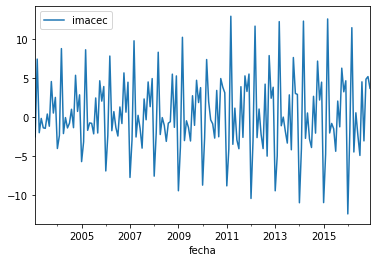

In [6]:
# Primera diferencia del Imacec
imacec1 = imacec.diff().dropna()
fig, ax = plt.subplots()
imacec1.plot(ax=ax)
plt.show()

A continuación se realiza el test de Dickey-Fuller aumentado para testear la presencia de raíces unitarias. 
- El primer caso corresponde al modelo con intercepto para la serie en niveles. No se puede rechazar la hipótesis de raíz unitaria. 
- El segundo caso corresponde al modelo estacionario en tendencia, es decir, el modelo con intercepto y tendencia determinística. En este caso se rechaza la nula de raíz unitaria. Hay que mencionar que este test habría sido no significativo si hubieramos utilizado la serie completa de datos. 
- Por último, se testea el modelo sólo con intercepto para la serie en primera diferencia. No se puede rechazar la presencia de raíz unitaria.

In [7]:
# Test de Dickey-Fuller
# Modelo sólo con constante para la serie en niveles
test1 = adfuller(imacec['imacec'])
print('Modelo sólo con constante para la serie en niveles: \n', test1, '\n')
# Modelo con constante y tendencia para la serie en niveles
test2 = adfuller(imacec['imacec'], regression='ct')
print('Modelo con constante y tendencia para la serie en niveles: \n', test2, '\n')
# Modelo sólo con constante para la primera diferencia
test3 = adfuller(imacec1['imacec'])
print('Modelo sólo con constante para la primera diferencia: \n', test3, '\n')

Modelo sólo con constante para la serie en niveles: 
 (-1.2650260004978429, 0.6450172721948815, 14, 153, {'1%': -3.473829775724492, '5%': -2.880622899711496, '10%': -2.5769448985432954}, 515.754921120192) 

Modelo con constante y tendencia para la serie en niveles: 
 (-3.6350218166987682, 0.027008872883231037, 14, 153, {'1%': -4.019192449915219, '5%': -3.439584098940215, '10%': -3.144123265603392}, 504.56028994422326) 

Modelo sólo con constante para la primera diferencia: 
 (-2.2881688454149463, 0.17581215100418712, 14, 152, {'1%': -3.474120870218417, '5%': -2.880749791423677, '10%': -2.5770126333102494}, 509.455751603114) 



A continuación se profundiza en el análisis del componente estacional. El siguiente análisis descompone la serie en su tendencia, componente estacional y residuo. Se observa que el componente estacional es muy marcado, y que el residuo parece ser estacionario, lo que sugiere que modelar el componente estacional es la estrategia correcta a seguir.

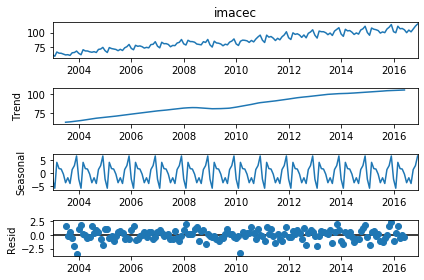

In [8]:
# Descomposición estacional aditiva
decomp = seasonal_decompose(imacec['imacec'], period=12)
decomp.plot()
plt.show()

En el siguiente gráfico se muestra la función de autocorrelación de la serie sin tendencia. Se extrajo la tendencia usando una media móvil de 24 meses. Se observa una correlación significativa cada 12 meses, lo que indicaría la frecuencia de la estacionalidad.

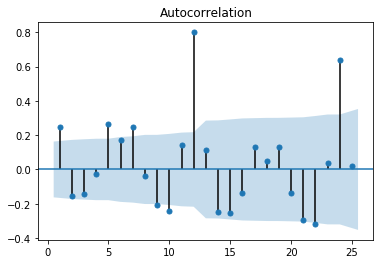

In [9]:
# Autocorrelación de serie sin tendencia
imacecdt = imacec - imacec.rolling(24).mean()
imacecdt = imacecdt.dropna()
# Plot the ACF
fig, ax1 = plt.subplots()
plot_acf(imacecdt['imacec'], lags=25, zero=False, ax=ax1)
plt.show()

A continuación se toma la primera diferencia de la serie en niveles, y luego la primera diferencia estacional. Se grafica el resultado y luego se realiza el test de Dickey-Fuller aumentado (modelo sólo con intercepto). El test rechaza la presencia de raíz unitaria con un alto nivel de confianza, por lo que se opta por modelar el componente estacional del IMACEC.

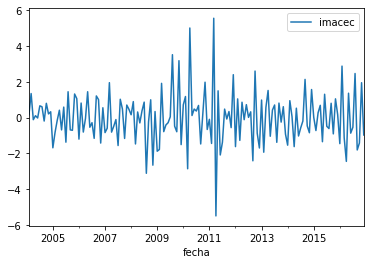

Test ADF: 
 (-4.12338236655283, 0.0008858320324709626, 11, 143, {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}, 449.70547654547164)


In [10]:
# Primera diferencia estacional
imacecds = imacec.diff(1).diff(12).dropna()
fig, ax = plt.subplots()
imacecds.plot(ax=ax)
plt.show()

test4 = adfuller(imacecds['imacec'])
print('Test ADF: \n', test4)

El siguiente paso es determinar cuál es el mejor modelo a estimar, lo que se hace automáticamente con el paquete *pmdarima*, a partir de una serie de parámetros predefinidos. La frecuencia del componente estacional se establece en 12 meses. El modelo tomará la primera diferencia de la serie en niveles, y la primera diferencia para el componente estacional. Los parámetros p y q (ARMA) se buscarán entre los valores 0 al 12 para la serie en niveles, y entre el 0 y 4 para el componente estacional. Se utiliza el criterio de información de Akaike para detrminar cuál es el mejor modelo. Por último, se utiliza el método stepwise para seleccionar el modelo de forma inteligente, y reducir el número de iteraciones.

In [11]:
# Selección automática del mejor modelo
model = pm.auto_arima(imacec,
                      seasonal=True, m=12,
                      d=1, D=1, 
                      start_p=0, start_q=0,
                      max_p=12, max_q=12,
                      max_P=4, max_Q=4,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      information_criterion='aic',
                      stepwise=True
                      ) 

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=522.808, BIC=534.982, Fit time=0.420 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=553.887, BIC=559.974, Fit time=0.032 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=494.090, BIC=506.264, Fit time=0.398 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=487.908, BIC=500.081, Fit time=0.463 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=489.665, BIC=504.882, Fit time=0.718 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=515.714, BIC=524.844, Fit time=0.147 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=489.709, BIC=504.926, Fit time=1.811 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=490.872, BIC=509.132, Fit time=2.529 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=488.505, BIC=503.722, Fit time=0.585 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 

El mejor modelo es el **SARIMAX(1,1,3)x(0,1,1,12)**.

In [12]:
# Print model summary
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -235.025
Date:                              Tue, 07 Jul 2020   AIC                            484.051
Time:                                      15:49:32   BIC                            505.355
Sample:                                           0   HQIC                           492.704
                                              - 168                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0178      0.063     -0.282      0.778      -0.142       0.106
ar.L1         -0.76

Los estadísticos de diagnóstico de los residuos se ven bien. Los residuos estarían no correlacionados, aunque su distribución no es normal, lo que se debería al efecto de unos poco outliers. Por lo tanto, se acepta esta especificación.

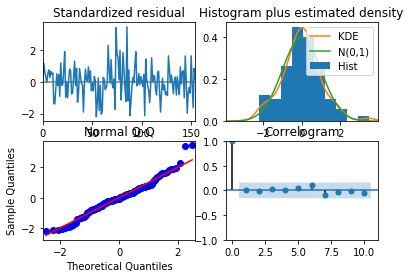

In [13]:
# Gráfico diagnóstico
model.plot_diagnostics()
plt.show()

Luego se estima el mejor modelo y se hace una predicción fuera de la muestra

In [14]:
bestModel = SARIMAX(imacec, 
                    order=(1,1,3), 
                    seasonal_order=(0,1,1,12), 
                    trend='c')
results = bestModel.fit()
predictions = results.get_forecast(steps=36)

imacec_pred = predictions.predicted_mean
confidence_intervals = predictions.conf_int()
lower_limits = confidence_intervals.loc[:,'lower imacec']
upper_limits = confidence_intervals.loc[:,'upper imacec']

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Por último, se grafica la predicción y se compara con los datos reales de IMACEC.

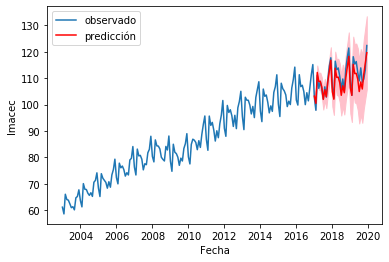

In [16]:
plt.plot(imacec_test.index, imacec_test, label='observado')
plt.plot(imacec_pred.index, imacec_pred, color='r', label='predicción')
plt.fill_between(imacec_pred.index, lower_limits, upper_limits, color='pink')
plt.xlabel('Fecha')
plt.ylabel('Imacec')
plt.legend(loc='upper left')
plt.show()

La predicción pareciera ajustarse bastante bien a la realidad. Este tipo de modelos es muy útil para proyectar series de tiempo en el futuro, y se puede complementar con variables exógenas adicionales, que ayuden a obtener mejores predicciones.